# covEcho (YOLO) - Regression Analysis
Only small parts of this notebook made it into the thesis since the results were quite bad. The notebook is kept for reference.

In [1]:
import os
import pandas as pd
import glob

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

# Analysis

### Load yolo_detections_df if it already exists

In [2]:
import pandas as pd
import os

if os.path.exists("yolo_detection_df.csv"):
    yolo_detection_df = pd.read_csv("yolo_detection_df.csv")
else:
    print("Yolo file does not exist")

if os.path.exists("df.csv"):
    df = pd.read_csv("df.csv")
else:
    print("df file does not exist")

#### Add manual severity labels

In [3]:
severity_manual = get_manual_severity_scores()

# Merge manual severity scores with yolo severity scores
yolo_detection_df = yolo_detection_df.merge(severity_manual[["video_name", "Severity Score"]], on="video_name", how="left")

# Rename Severity Score to manual_severity_score
yolo_detection_df.rename(columns={"Severity Score": "manual_severity_score"}, inplace=True)

Number of discarded rows: 8


In [4]:
# Add the class names from the yolo net

# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
class_names = ["Airbronchograms", "Alines", "Blines", "Bpatch", "Consolidations", "Pleura", "Rib", "Shadow"]
class_name_2_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_2_class_name = {idx: class_name for idx, class_name in enumerate(class_names)}

# yolo_detection_df["class_name"] = yolo_detection_df["class"].apply(lambda x: class_names[x])

idx_2_class_name

{0: 'Airbronchograms',
 1: 'Alines',
 2: 'Blines',
 3: 'Bpatch',
 4: 'Consolidations',
 5: 'Pleura',
 6: 'Rib',
 7: 'Shadow'}

In [ ]:
# This dataframe contains one row per object detected by the YOLONet in all frames of all bluepoint-videos of all patients
# The columns are:
# - class: the class of the object detected by the YOLONet
# - confidence: the confidence of the YOLONet in the detection
# - x: the x-coordinate of the center of the bounding box
# - y: the y-coordinate of the center of the bounding box
# - w: the width of the bounding box
# - h: the height of the bounding box
# - area: the area of the bounding box
# - video_name: the name of the video
# - Frame: the frame number
#...
# - Patient ID: the ID of the patient
# - Bluepoint: the name of the bluepoint
# - COVID19: the clinical diagnosis of the patient
# - yolo_quality_score: the quality score of the YOLONet
# - yolo_quality: the quality of the YOLONet
# - yolo_severity_score: the severity score of the YOLONet
# - class_name: the name of the class
yolo_detection_df.head()

In [6]:
yolo_detection_df["yolo_quality_score"].value_counts()

85.0     13508
100.0    12306
75.0     11907
55.0      9347
90.0      5616
Name: yolo_quality_score, dtype: int64

### Possibly filter the df before analysis

In [7]:
# Filter out detections with low quality
# yolo_detection_df = yolo_detection_df[yolo_detection_df["yolo_quality"] == "Excellent,"]

### Severity Score analysis

In [8]:
# Frame-wise severity score
frame_level = yolo_detection_df.groupby(["Frame", "video_name"]).first().reset_index().drop(columns=["class", "confidence", "x", "y", "w", "h", "area", "class_name"])

# Filter out frames with low quality
severity_filtered = frame_level[frame_level.yolo_severity_score >= 0]

In [ ]:
yolo_detection_df

# Class area analysis

In [10]:
# Adding information whether class is pathological or not. For now I assume class 0, 2, 3 and 4 are pathological
# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
pathological_classes = [0, 2, 3, 4]
non_pathological_classes = [1, 5, 6, 7]
pathological_class_names = [class_names[x] for x in pathological_classes]
non_pathological_class_names = [class_names[x] for x in non_pathological_classes]

## Correlate manual severity score with class count of different classes

In [ ]:
yolo_detection_df_pivot = yolo_detection_df.pivot_table(index=["video_name", "Frame"], columns="class_name", values="area", aggfunc="count").fillna(0).reset_index()
# Add Bluepoint, Patient ID and manual severity score
yolo_detection_df_pivot = yolo_detection_df_pivot.merge(yolo_detection_df[["video_name", "Frame", "Bluepoint", "Patient ID", "manual_severity_score", "COVID19"]], on=["video_name", "Frame"], how="left")
yolo_detection_df_pivot = yolo_detection_df_pivot.drop_duplicates().sort_values(by=["Patient ID", "Bluepoint", "Frame"]).reset_index(drop=True)
yolo_detection_df_pivot.head()

#### Frame level

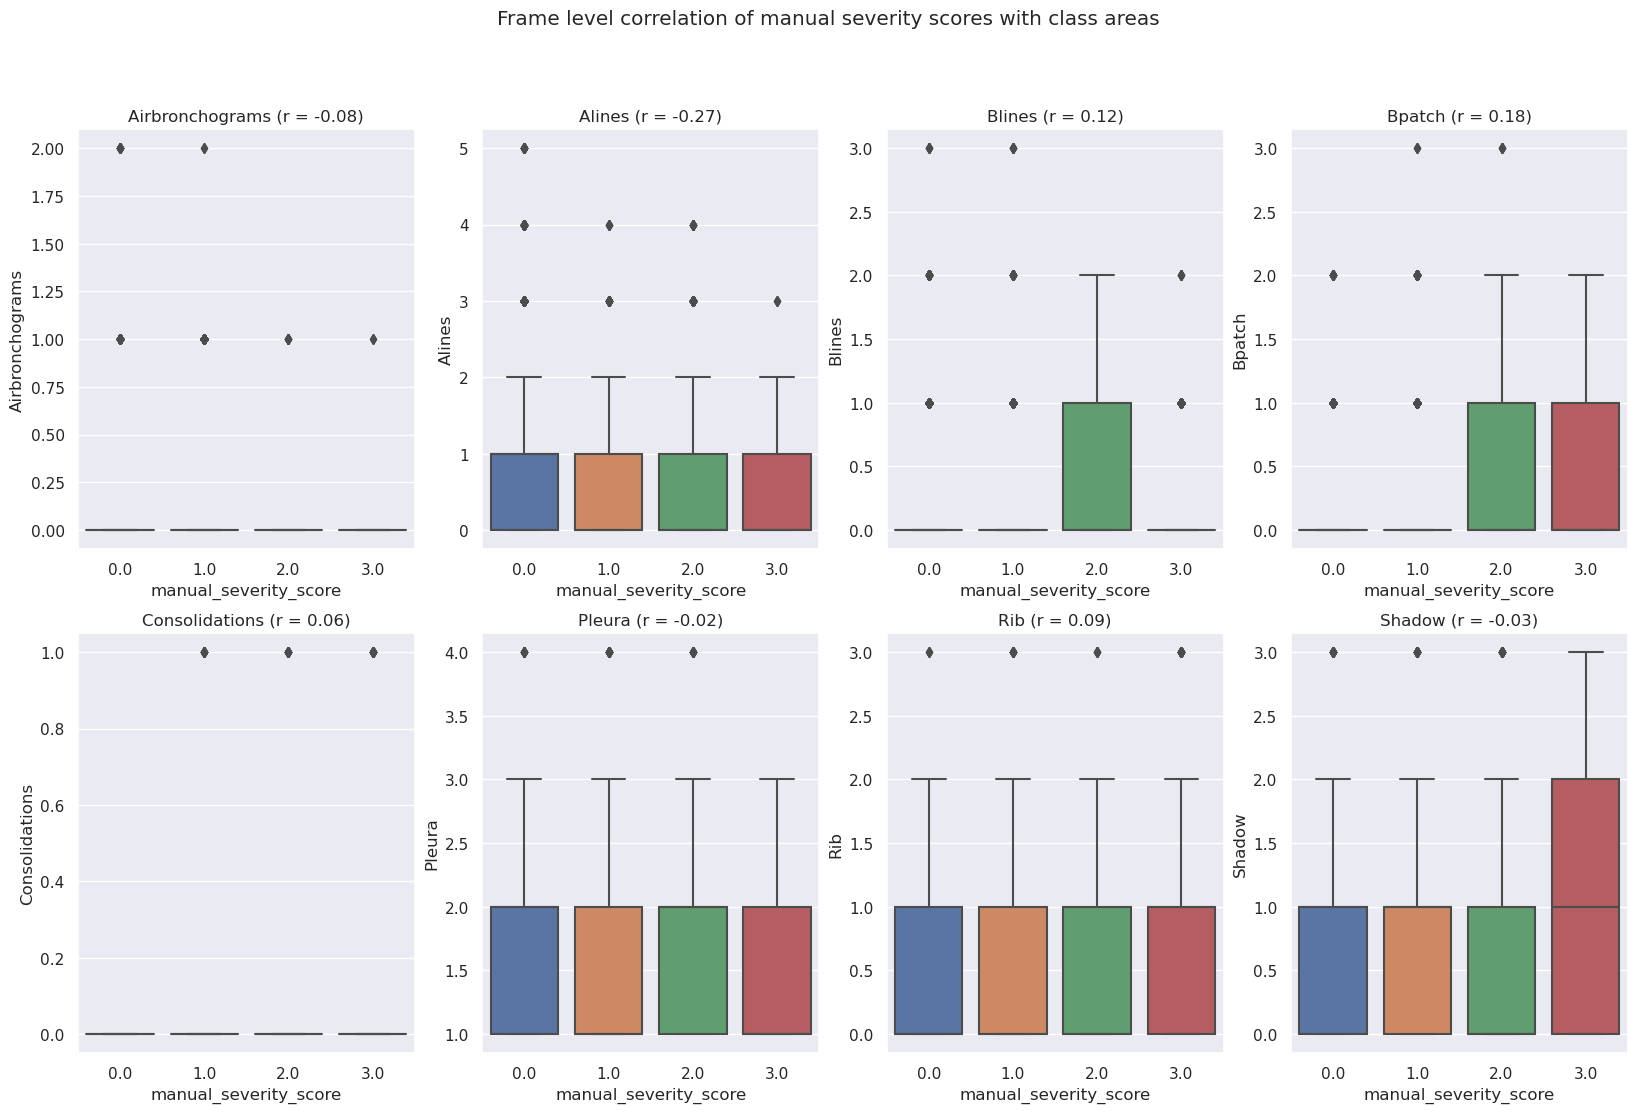

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Plot and correlate manual severity scores with class areas
# Boxplot for each test_column
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i, ax in enumerate(axs.flatten()):
    cl = class_names[i]
    sns.boxplot(data=yolo_detection_df_pivot, y=cl, x="manual_severity_score", ax=ax)
    corr = yolo_detection_df_pivot.manual_severity_score.corr(yolo_detection_df_pivot[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")

plt.suptitle("Frame level correlation of manual severity scores with class areas")
plt.show()

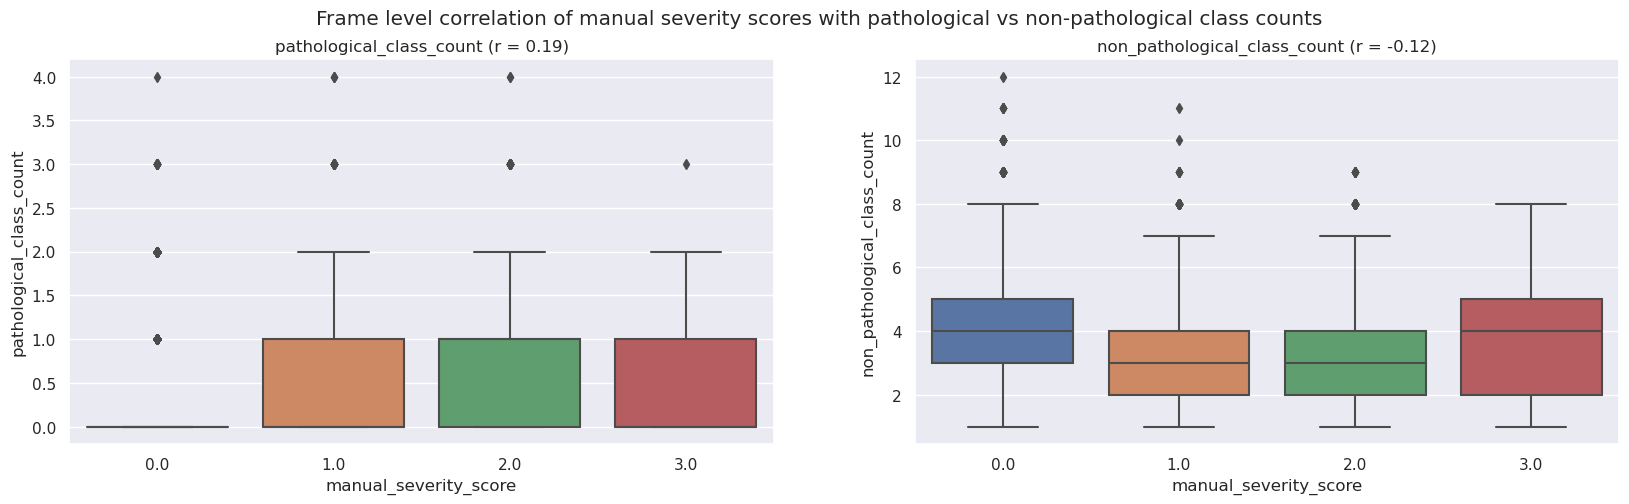

In [13]:
yolo_detection_df_pivot["pathological_class_count"] = yolo_detection_df_pivot[pathological_class_names].sum(axis=1)
yolo_detection_df_pivot["non_pathological_class_count"] = yolo_detection_df_pivot[non_pathological_class_names].sum(axis=1)
yolo_detection_df_pivot

# Correlate manual severity scores with pathological vs non_pathological class counts
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

path_list = ["pathological_class_count", "non_pathological_class_count"]

for i, ax in enumerate(axs.flatten()):
    path = path_list[i]
    sns.boxplot(data=yolo_detection_df_pivot, y=path, x="manual_severity_score", ax=ax)
    corr = yolo_detection_df_pivot.manual_severity_score.corr(yolo_detection_df_pivot[path])
    ax.set_title(f"{path} (r = {corr:.2f})")

plt.suptitle("Frame level correlation of manual severity scores with pathological vs non-pathological class counts")
plt.show()

#### Video level

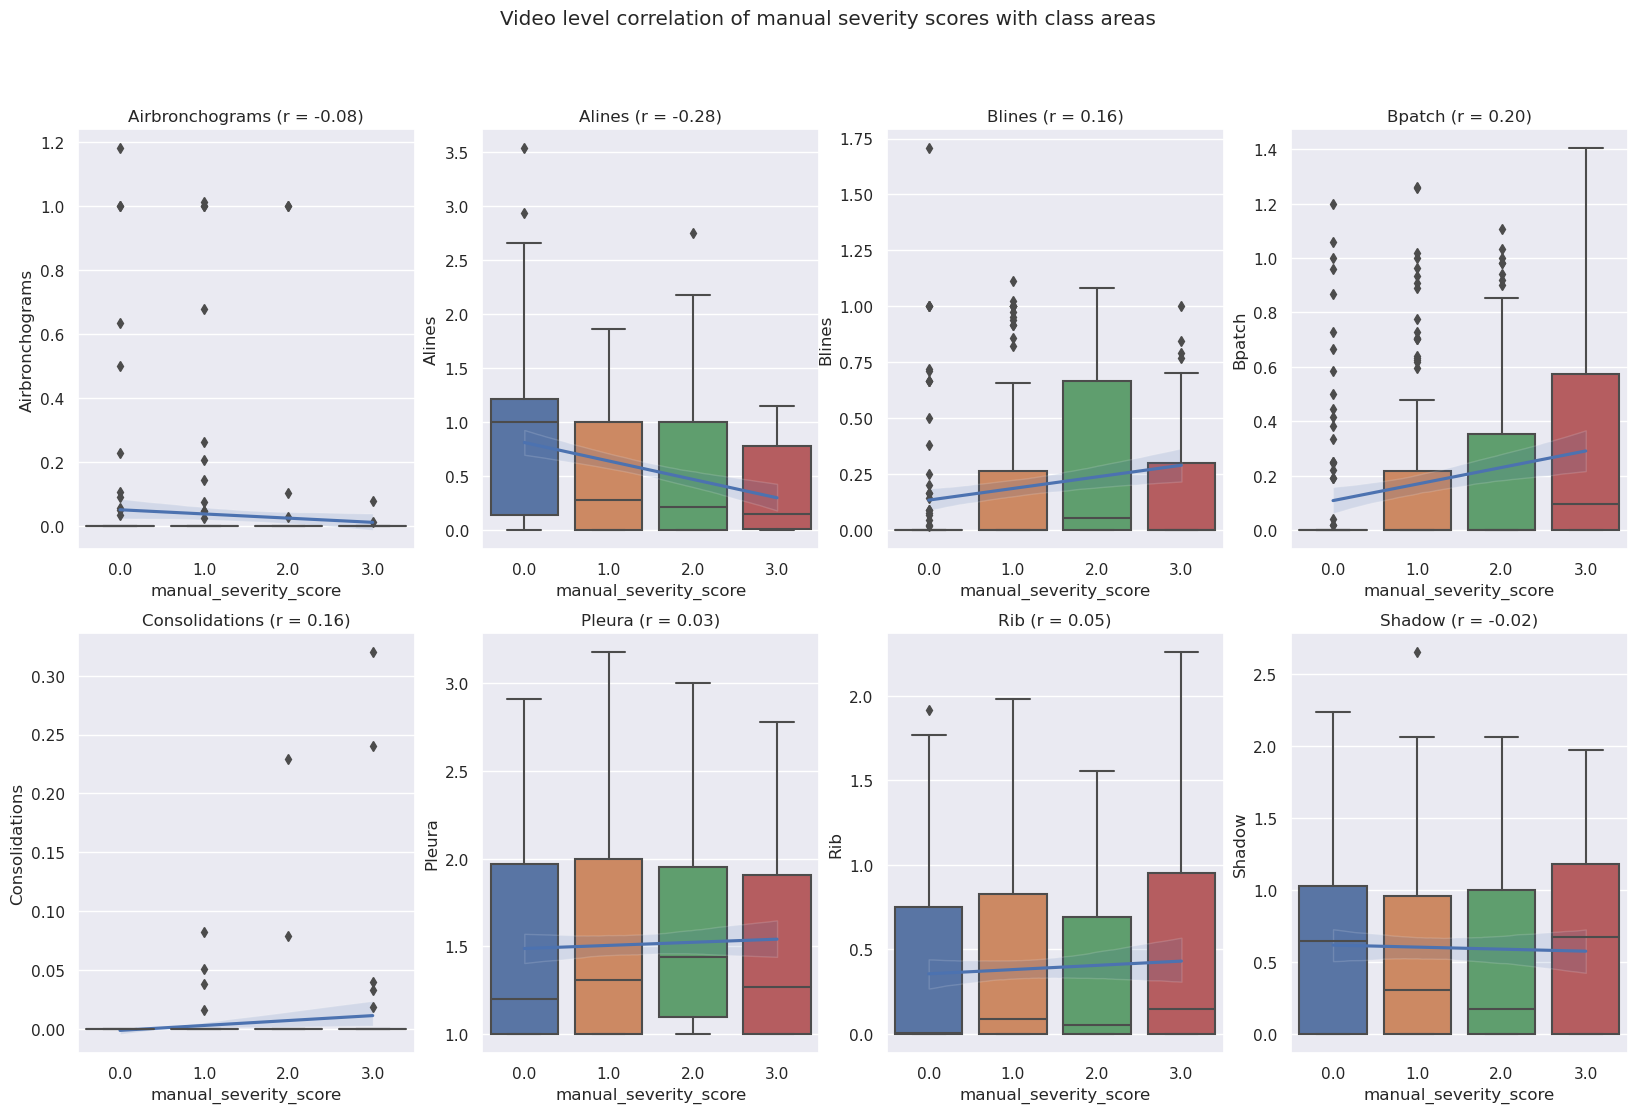

In [14]:
# Group by video and sum all pixels
grp = yolo_detection_df_pivot.groupby(["video_name"])
agg_dict = {cl: "mean" for cl in class_names}
agg_dict["manual_severity_score"] = "first"
video_lvl_mean = grp.agg(agg_dict).reset_index()

sns.set()

# Plot and correlate manual severity scores with class areas
# Boxplot for each test_column
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i, ax in enumerate(axs.flatten()):
    cl = class_names[i]
    sns.boxplot(data=video_lvl_mean, y=cl, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=video_lvl_mean, y=cl, x="manual_severity_score", ax=ax, scatter=False)
    corr = video_lvl_mean.manual_severity_score.corr(video_lvl_mean[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")

plt.suptitle("Video level correlation of manual severity scores with class areas")
plt.show()

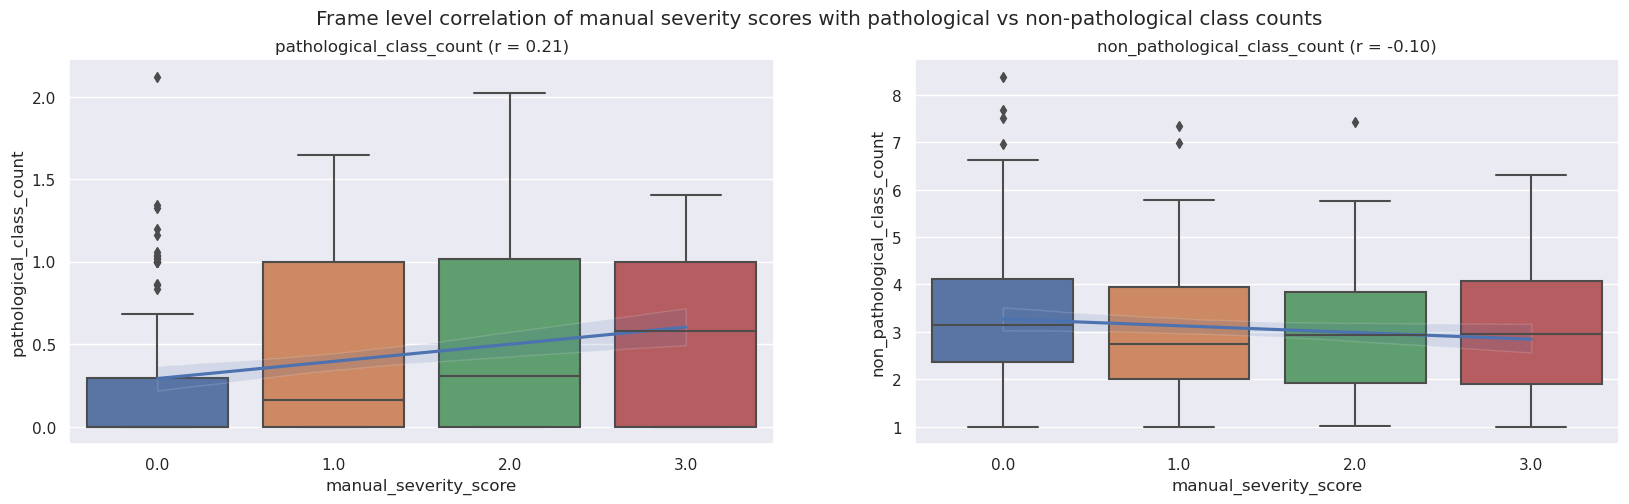

In [15]:
video_lvl_mean["pathological_class_count"] = video_lvl_mean[pathological_class_names].sum(axis=1)
video_lvl_mean["non_pathological_class_count"] = video_lvl_mean[non_pathological_class_names].sum(axis=1)

# Correlate manual severity scores with pathological vs non_pathological class counts
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

path_list = ["pathological_class_count", "non_pathological_class_count"]

for i, ax in enumerate(axs.flatten()):
    path = path_list[i]
    sns.boxplot(data=video_lvl_mean, y=path, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=video_lvl_mean, y=path, x="manual_severity_score", ax=ax, scatter=False)
    corr = video_lvl_mean.manual_severity_score.corr(video_lvl_mean[path])
    ax.set_title(f"{path} (r = {corr:.2f})")

plt.suptitle("Frame level correlation of manual severity scores with pathological vs non-pathological class counts")
plt.show()

#### Patient Level

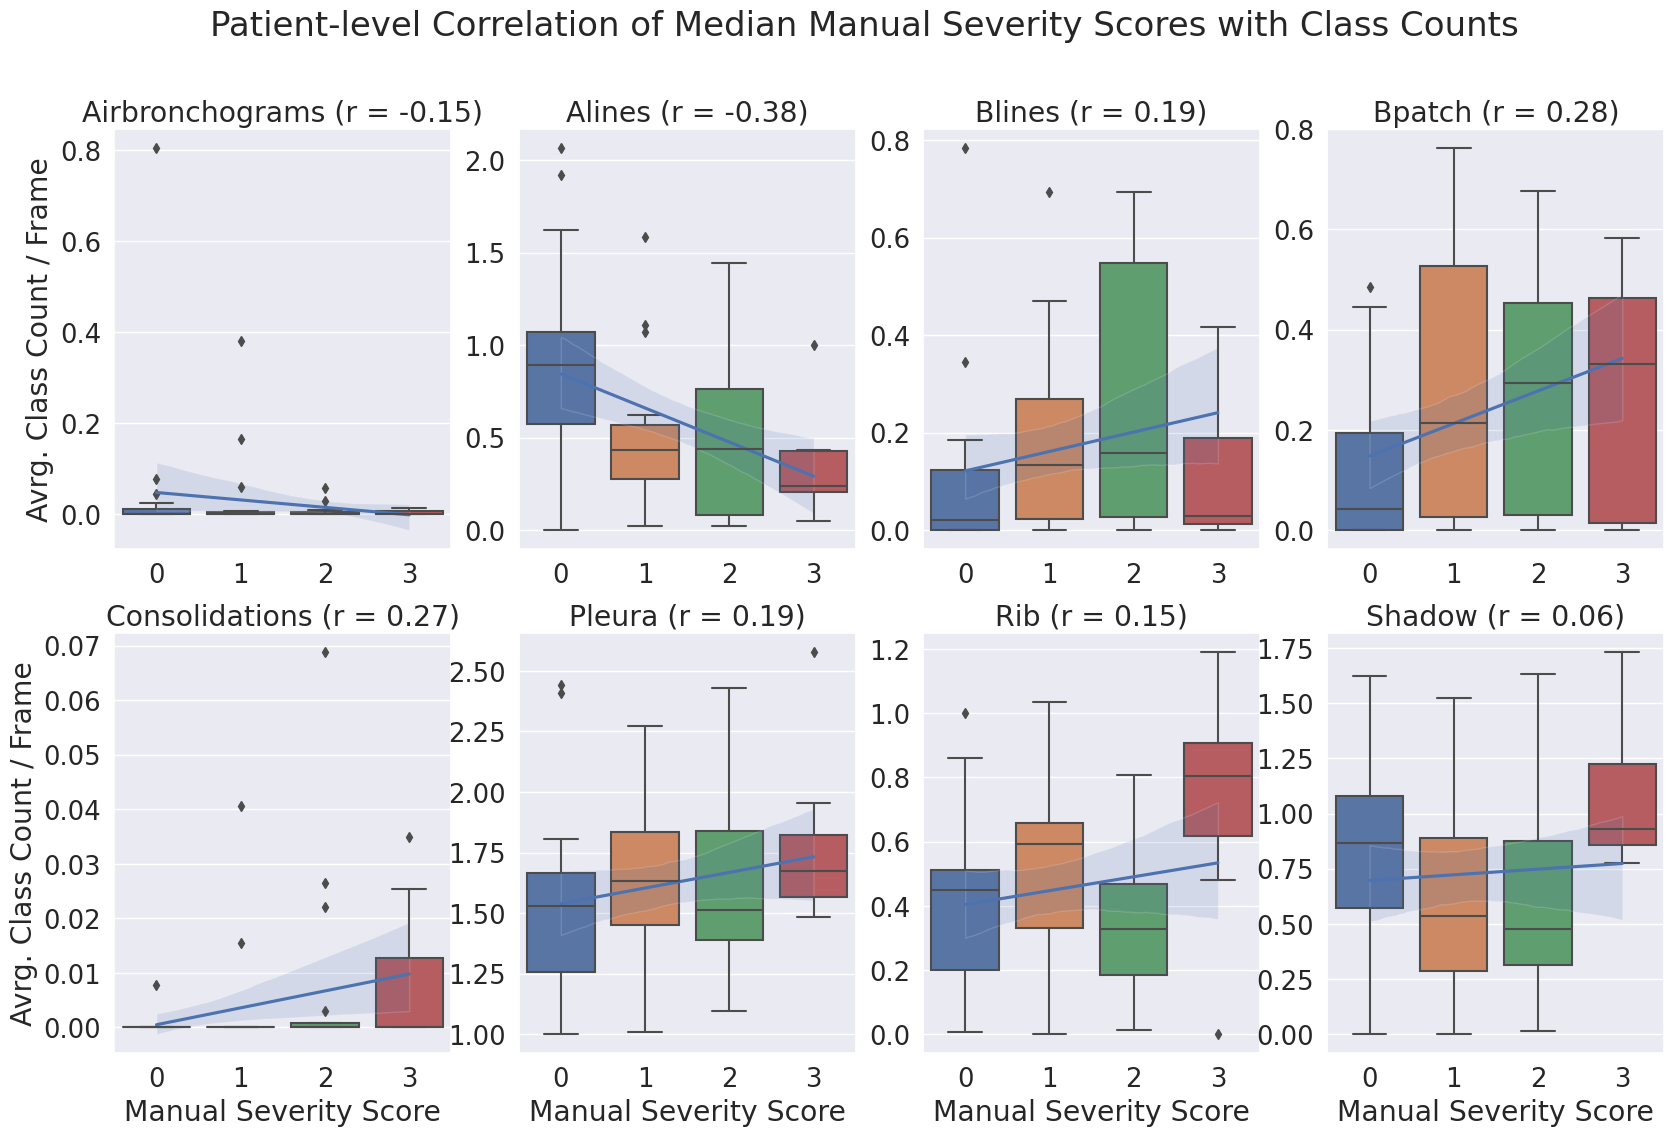

In [16]:
# Group by video and sum all pixels
grp = yolo_detection_df_pivot.groupby(["Patient ID"])
agg_dict = {cl: "mean" for cl in class_names}
agg_dict["manual_severity_score"] = "median"
patient_lvl_mean = grp.agg(agg_dict).reset_index()
# manual_severity_score as int
patient_lvl_mean["manual_severity_score"] = patient_lvl_mean["manual_severity_score"].astype(int)

sns.set(font_scale=1.7)

# Plot and correlate manual severity scores with class areas
# Boxplot for each test_column
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i, ax in enumerate(axs.flatten()):
    cl = class_names[i]
    sns.boxplot(data=patient_lvl_mean, y=cl, x="manual_severity_score", ax=ax).set_xlabel("Manual severity score")
    # Add regression line to plot
    sns.regplot(data=patient_lvl_mean, y=cl, x="manual_severity_score", ax=ax, scatter=False)

    corr = patient_lvl_mean.manual_severity_score.corr(patient_lvl_mean[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")
    if i == 0 or i == 4:
        ax.set_ylabel("Avrg. Class Count / Frame")
    else:
        ax.set_ylabel("")
    if i > 3:
        ax.set_xlabel("Manual Severity Score")
    else:
        ax.set_xlabel("")

    #ax.set_xlabel("Manual severity score")
    #ax.set_ylabel("Avrg. Class Count / Frame")

plt.suptitle("Patient-level Correlation of Median Manual Severity Scores with Class Counts")
plt.show()

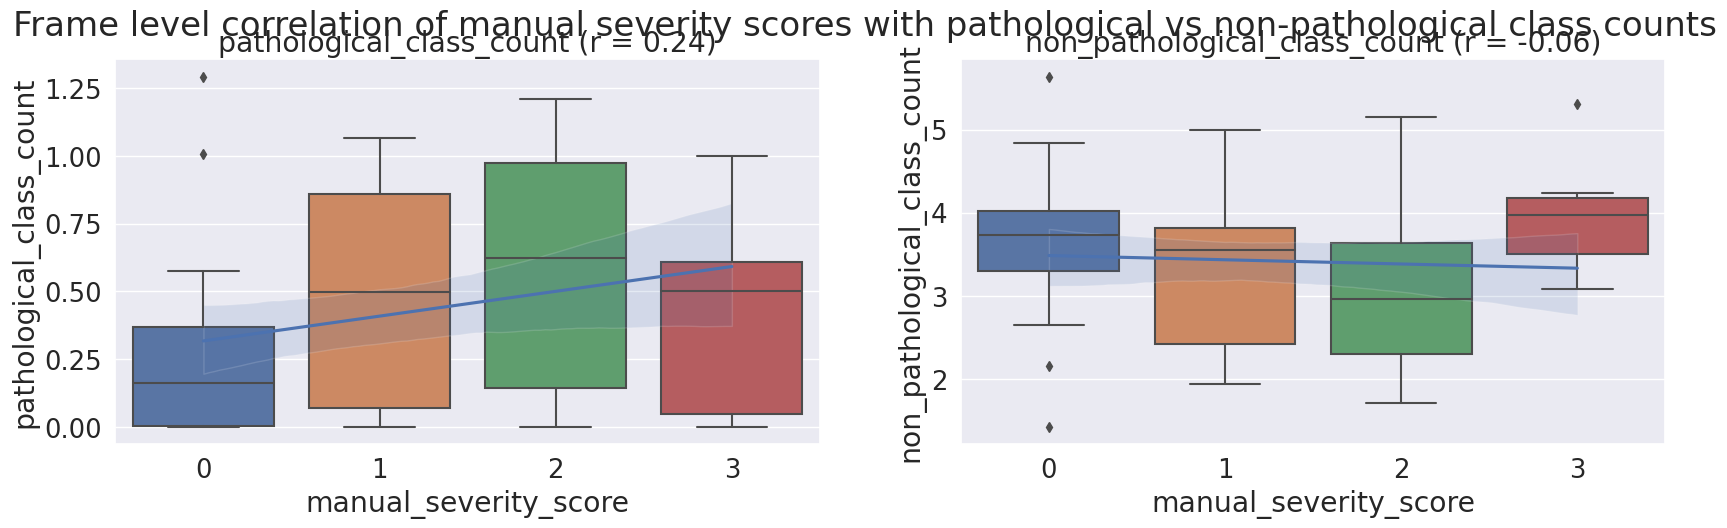

In [17]:
patient_lvl_mean["pathological_class_count"] = patient_lvl_mean[pathological_class_names].sum(axis=1)
patient_lvl_mean["non_pathological_class_count"] = patient_lvl_mean[non_pathological_class_names].sum(axis=1)

# Correlate manual severity scores with pathological vs non_pathological class counts
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

path_list = ["pathological_class_count", "non_pathological_class_count"]

for i, ax in enumerate(axs.flatten()):
    path = path_list[i]
    sns.boxplot(data=patient_lvl_mean, y=path, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=patient_lvl_mean, y=path, x="manual_severity_score", ax=ax, scatter=False)
    corr = patient_lvl_mean.manual_severity_score.corr(patient_lvl_mean[path])
    ax.set_title(f"{path} (r = {corr:.2f})")

plt.suptitle("Frame level correlation of manual severity scores with pathological vs non-pathological class counts")
plt.show()

In [18]:
# Add class count, weightes class count and weighted class area by confidence
yolo_detection_df["area_weighted"] = yolo_detection_df["area"] * yolo_detection_df["confidence"]
grp = yolo_detection_df.groupby(["video_name", "class"])
video_lvl = grp.agg({"class": "count", "confidence": "sum", "area": "sum", "area_weighted": "sum"})
video_lvl = video_lvl.rename(columns={"class": "class_count", "confidence": "class_count_conf_weighted", "area": "area", "area_weighted": "area_conf_weighted"}).reset_index()

# Add frame count
frame_count_per_video = yolo_detection_df[["video_name", "Frame"]].drop_duplicates().groupby(["video_name"]).count().reset_index().rename(columns={"Frame": "Frame_count"})
video_lvl = pd.merge(video_lvl, frame_count_per_video, on="video_name")


# Devide by frame count to account for different video lengths
video_lvl["area"] = video_lvl["area"] / video_lvl["Frame_count"]
video_lvl["area_conf_weighted"] = video_lvl["area_conf_weighted"] / video_lvl["Frame_count"]
video_lvl["class_count"] = video_lvl["class_count"] / video_lvl["Frame_count"]
video_lvl["class_count_conf_weighted"] = video_lvl["class_count_conf_weighted"] / video_lvl["Frame_count"]

# Add classes with 0 area
possible_classes = list(range(len(class_names)))
video_names = yolo_detection_df.video_name.unique().tolist()
from itertools import product
idx_df =  pd.DataFrame(list(product(possible_classes,video_names))).rename(columns={0:'class',1:'video_name'})

video_lvl = pd.merge(idx_df, video_lvl, on=["video_name", "class"], how="left").fillna(0).sort_values(by=["video_name", "class"])

video_lvl["class_name"] = video_lvl["class"].map(lambda x: class_names[x])

patient_data = yolo_detection_df.groupby(["Patient ID", "video_name"]).agg({"COVID19": "first","Bluepoint": "first", "yolo_severity_score": "mean", "manual_severity_score": "first"}).reset_index()
video_level = pd.merge(video_lvl, patient_data, on="video_name").sort_values(by=["Patient ID", "Bluepoint", "class"]).reset_index(drop=True)
# Reorder columns
video_level = video_level[["Patient ID", "COVID19", "Bluepoint", "video_name", "yolo_severity_score", "class", "class_name", "class_count", "class_count_conf_weighted", "area", "area_conf_weighted", "manual_severity_score"]]
video_level.head()

,Patient ID,COVID19,Bluepoint,video_name,yolo_severity_score,class,class_name,class_count,class_count_conf_weighted,area,area_conf_weighted,manual_severity_score
0,A001,0,L1,image_147763479101025,2.0,0,Airbronchograms,0.000000,0.000000,0.000000,0.000000,3.0
1,A001,0,L1,image_147763479101025,2.0,1,Alines,0.000000,0.000000,0.000000,0.000000,3.0
2,A001,0,L1,image_147763479101025,2.0,2,Blines,0.000000,0.000000,0.000000,0.000000,3.0
3,A001,0,L1,image_147763479101025,2.0,3,Bpatch,1.403846,0.555717,0.200159,0.079026,3.0
4,A001,0,L1,image_147763479101025,2.0,4,Consolidations,0.000000,0.000000,0.000000,0.000000,3.0


To beginn we try 4 different methods to aggregate the classes over time. 
1. Simple class count per video divided by the number of frames (avrg number of classes per frame).
2. The class count weighted by the networks confidence divided by n frames.
3. The area of the detected classes summed up divided by n frames. Testing the hypothesis that the affected area has a predictive power for covid.
4. The area weighted by the networks confidence /n_Frames.

### Try different standard models using all class areas

In [19]:
# from ml_pipeline import ModelEvaluation

Regressor = ModelEvaluation(mode="regression")

Train models on accumulated area of all detected classes:

In [20]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID", "manual_severity_score"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    class_area_per_video_pivot = class_area_per_video_pivot.dropna(subset=["manual_severity_score"])
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[class_names]
    y = class_area_per_video_pivot["manual_severity_score"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


The models performance of 57% accuracy is not great but comparable to our first approaches of training the NN. It can't compete with the best values of the severity analysis so far.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

area v.s. area_conf_weighted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.945e+02
class_count v.s. class_count_conf_weighted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.245e+02
area v.s. class_count: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.665e+02


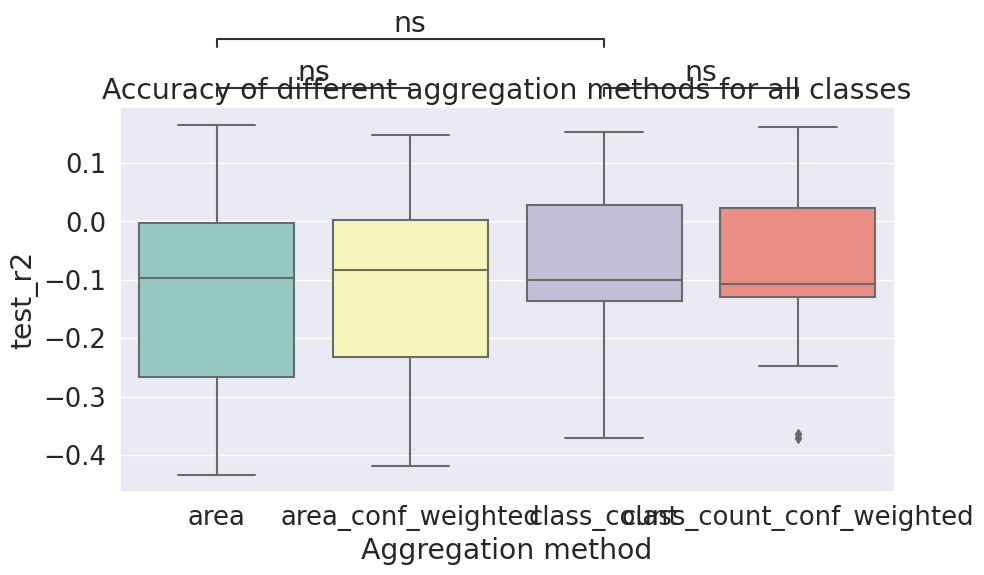

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count')]

scores_all_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=scores_all_classes, x="Aggregation method", y="test_r2", palette="Set3")
add_stat_annotation(ax, data=scores_all_classes, x="Aggregation method", y="test_r2",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.title("Accuracy of different aggregation methods for all classes")
plt.show()

Comparing the different aggregation strategies show that incorporating the networks confidence does not significantly improve the network.
We can also see that the class count is not significantly more predicitve than the summed up area. This suggests to reject the hyptothesis that the area for this network has a significant informative value.

See if restricting to pathological classes makes a change

In [22]:
# Adding information whether class is pathological or not. For now I assume class 0, 2, 3 and 4 are pathological
# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
pathological_classes = [0, 2, 3, 4]
non_pathological_classes = [1, 5, 6, 7]
pathological_class_names = [class_names[x] for x in pathological_classes]
non_pathological_class_names = [class_names[x] for x in non_pathological_classes]
video_level["pathological_class"] = video_level["class"].apply(lambda x: 1 if x in pathological_classes else 0)

Train models on aggregated class (area) of all pathological classes:

In [23]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID", "manual_severity_score"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    class_area_per_video_pivot = class_area_per_video_pivot.dropna(subset=["manual_severity_score"])
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[pathological_class_names]
    y = class_area_per_video_pivot["manual_severity_score"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


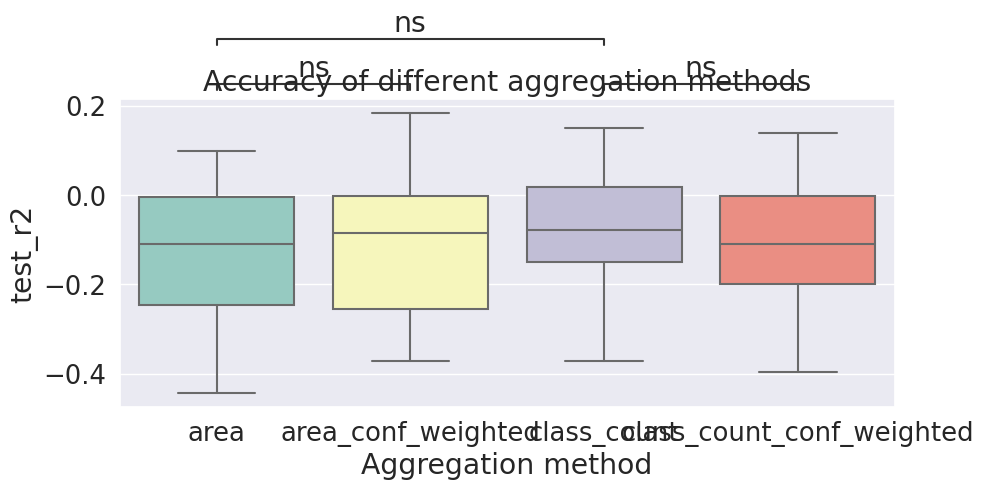

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count'),
        ]

scores_pathological_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=scores_pathological_classes, x="Aggregation method", y="test_r2", palette="Set3")
add_stat_annotation(ax, data=scores_pathological_classes, x="Aggregation method", y="test_r2",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
plt.title("Accuracy of different aggregation methods")
plt.show()

When restricting to the pathological classes there is no significant difference between either area or class_count and no significant difference when weighting by the networks confidence.

The mean of the class count is the highest which is why we will proceed using the class count as primary aggregation method.

In [26]:
from scipy.stats import mannwhitneyu
# Mann-Whitney U-Test
x0 = scores_all_classes["test_r2"]
x1 = scores_pathological_classes["test_r2"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean r2 all classes: {x0.mean():.4f}")
print(f"Mean r2 pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")



Mann–Whitney U Test: statistic=5145.0000, p-value=0.7240
Mean r2 all classes: -0.0920
Mean r2 pathological classes: -0.0988
No significant difference


Testing on all trained models and all used aggregation strategies shows that restricting the model input to the pathological classes is not significantly better $(p > 0.05)$

This is to some extend not suprising since the information about the pathological classes is also contained in the full set of class names. Instead we check if restricting the model to only non-pathologocal classes decreases performance:

In [27]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID", "manual_severity_score"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    class_area_per_video_pivot = class_area_per_video_pivot.dropna(subset=["manual_severity_score"])
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[non_pathological_class_names]
    y = class_area_per_video_pivot["manual_severity_score"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


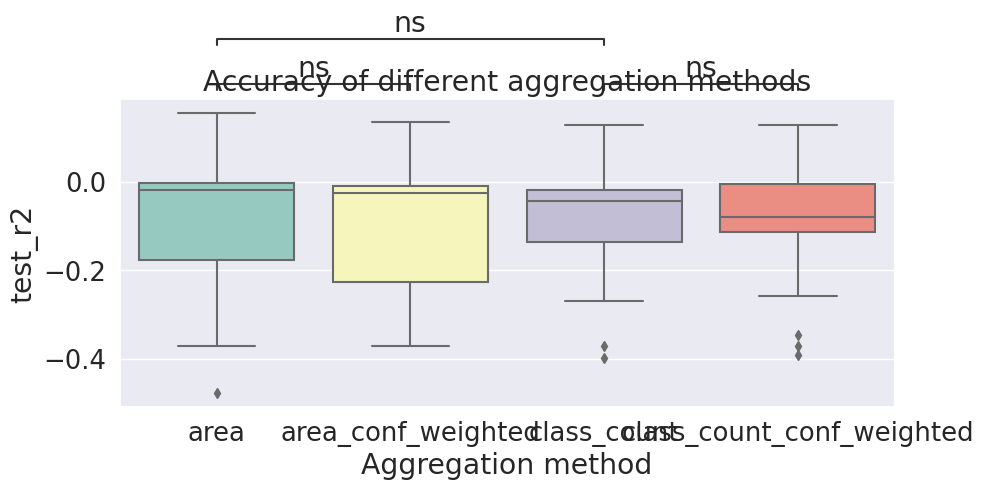

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count'),
        ]

scores_non_pathological_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=scores_non_pathological_classes, x="Aggregation method", y="test_r2", palette="Set3")
add_stat_annotation(ax, data=scores_non_pathological_classes, x="Aggregation method", y="test_r2",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
plt.title("Accuracy of different aggregation methods")
plt.show()

In [29]:
# Mann-Whitney U-Test
x0 = scores_all_classes["test_r2"]
x1 = scores_non_pathological_classes["test_r2"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean test_r2 all classes: {x0.mean():.4f}")
print(f"Mean test_r2 non pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=4878.0000, p-value=0.7665
Mean test_r2 all classes: -0.0920
Mean test_r2 non pathological classes: -0.0847
No significant difference


Using all classes vs using only non-pathological classes for training makes a significant difference across all models.

### Patient level area analysis

In [30]:
# Add class count, weightes class count and weighted class area by confidence
yolo_detection_df["area_weighted"] = yolo_detection_df["area"] * yolo_detection_df["confidence"]
grp = yolo_detection_df.groupby(["Patient ID", "class"])
patient_lvl = grp.agg({"class": "count", "confidence": "sum", "area": "sum", "area_weighted": "sum"})
patient_lvl = patient_lvl.rename(columns={"class": "class_count", "confidence": "class_count_conf_weighted", "area": "area", "area_weighted": "area_conf_weighted"}).reset_index()

# Add frame count
frame_count_per_patient = yolo_detection_df[["Patient ID", "Bluepoint", "Frame"]].drop_duplicates().groupby(["Patient ID"]).count().reset_index().rename(columns={"Frame": "Frame_count"}).drop(columns=["Bluepoint"])
patient_lvl = pd.merge(patient_lvl, frame_count_per_patient, on="Patient ID")


# Devide by frame count to get the average area per frame
patient_lvl["area"] = patient_lvl["area"] / patient_lvl["Frame_count"]
patient_lvl["area_conf_weighted"] = patient_lvl["area_conf_weighted"] / patient_lvl["Frame_count"]
patient_lvl["class_count"] = patient_lvl["class_count"] / patient_lvl["Frame_count"]
patient_lvl["class_count_conf_weighted"] = patient_lvl["class_count_conf_weighted"] / patient_lvl["Frame_count"]


# Add classes with 0 area
possible_classes = list(range(len(class_names)))
patient_names = yolo_detection_df["Patient ID"].unique().tolist()
from itertools import product
idx_df =  pd.DataFrame(list(product(possible_classes, patient_names))).rename(columns={0:'class',1:'Patient ID'})

patient_lvl = pd.merge(idx_df, patient_lvl, on=["Patient ID", "class"], how="left").fillna(0).sort_values(by=["Patient ID", "class"])

patient_lvl["class_name"] = patient_lvl["class"].map(lambda x: class_names[x])

patient_data = yolo_detection_df.groupby(["Patient ID"]).agg({"COVID19": "first", "yolo_severity_score": "mean", "manual_severity_score": "mean"}).reset_index()
patient_lvl = pd.merge(patient_lvl, patient_data, on="Patient ID").sort_values(by=["Patient ID", "class"]).reset_index(drop=True)
# Reorder columns
patient_lvl = patient_lvl[["Patient ID", "COVID19", "yolo_severity_score", "class", "class_name", "class_count", "class_count_conf_weighted", "area", "area_conf_weighted", "manual_severity_score"]]

In [31]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19", "manual_severity_score"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[class_names]
    y = class_area_per_patient_pivot["manual_severity_score"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

area v.s. class_count: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.878e-01 U_stat=2.675e+02


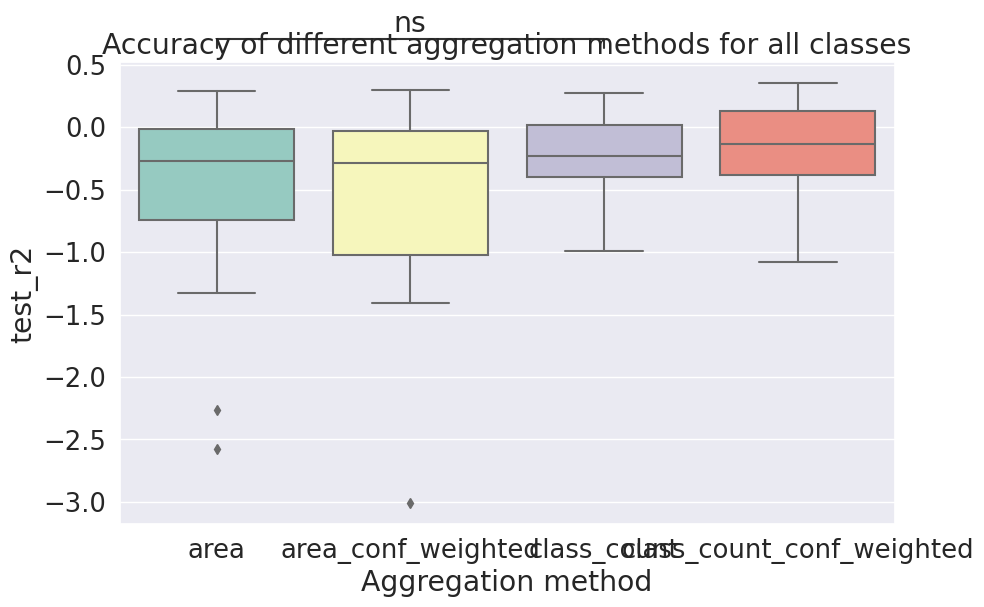

In [32]:
pairs = [('area', 'class_count'),
        # ('area_conf_weighted', 'area'),
        # ('class_count_conf_weighted', 'class_count'),
        ]

scores_all_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=scores_all_classes, x="Aggregation method", y="test_r2", palette="Set3")
add_stat_annotation(ax, data=scores_all_classes, x="Aggregation method", y="test_r2",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.title("Accuracy of different aggregation methods for all classes")
plt.show()

In [33]:
area_mean = scores_all_classes[scores_all_classes["Aggregation method"].isin(["area"])].mean().loc["test_r2"]
area_std = scores_all_classes[scores_all_classes["Aggregation method"].isin(["area"])].std().loc["test_r2"]
class_count_mean = scores_all_classes[scores_all_classes["Aggregation method"].isin(["class_count"])].mean().loc["test_r2"]
class_count_std = scores_all_classes[scores_all_classes["Aggregation method"].isin(["class_count"])].std().loc["test_r2"]

print(f"Area mean: {area_mean:.2f} +- {area_std:.2f}")
print(f"Class count mean: {class_count_mean:.2f} +- {class_count_std:.2f}")


Area mean: -0.48 +- 0.75
Class count mean: -0.21 +- 0.32


Again the patient level improves the results significantly. Similarly to before try using only pathological classes for prediction:

In [34]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19", "manual_severity_score"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[pathological_class_names]
    y = class_area_per_patient_pivot["manual_severity_score"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


Eyeballing the results the filtering for only the pathological classes makes for a slight improvement on the patient level.

In [35]:
scores_pathological_classes = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_r2"]
x1 = scores_pathological_classes["test_r2"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")


Mann–Whitney U Test: statistic=4979.0000, p-value=0.9600
Mean accuracy all classes: -0.3471
Mean accuracy pathological classes: -0.3152
No significant difference


In [36]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19", "manual_severity_score"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[non_pathological_class_names]
    y = class_area_per_patient_pivot["manual_severity_score"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [37]:
scores_non_pathological_classes = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_r2"]
x1 = scores_non_pathological_classes["test_r2"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy non-pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=4178.0000, p-value=0.0447
Mean accuracy all classes: -0.3471
Mean accuracy non-pathological classes: -0.1691
Significant difference


## Bluepoint information added to class area on video level

In [38]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19", "manual_severity_score"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Filter out video with Bluepoint == None
    class_area_per_video_pivot = class_area_per_video_pivot[class_area_per_video_pivot["Bluepoint"] != 'None']
    # Get list of Bluepoint values
    bluepoints = class_area_per_video_pivot.Bluepoint.unique().tolist()
    bluepoints.sort()
    # Create a dictionary for mapping Bluepoint values to integers
    bp2code = {bp: i for i, bp in enumerate(bluepoints)}
    code2bp = {i: bp for i, bp in enumerate(bluepoints)}
    # Map Bluepoint values to integers 
    class_area_per_video_pivot["Bluepoint_codes"] = class_area_per_video_pivot["Bluepoint"].apply(lambda x: bp2code[x])

    X = class_area_per_video_pivot[class_names + ["Bluepoint_codes"]]
    y = class_area_per_video_pivot["manual_severity_score"]

    # Train models
    scores, scores_mean = Regressor.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [39]:
scores_all_classes_plus_pb = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_r2"]
x1 = scores_all_classes_plus_pb["test_r2"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy classes + bp: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=2955.0000, p-value=0.0000
Mean accuracy all classes: -0.3471
Mean accuracy classes + bp: -0.0110
Significant difference


Adding information about where the video was taken interestingly does not improve the performance compared to the model simply using all pathological classes.

### Training one model per Bluepoint

In [40]:
bluepoint_models = pd.DataFrame()
bluepoint_models_all = pd.DataFrame()
for bp in bluepoints:
    print(f"Training model for {bp}...")
    bp_df = class_area_per_video_pivot[class_area_per_video_pivot["Bluepoint"] == bp]
    X = bp_df[class_names]
    y = bp_df["manual_severity_score"]

    scores, scores_mean = Regressor.train_models(X, y, plot=False)
    scores = pd.concat([scores], keys=[bp], names=['Bluepoint'])
    scores_mean = pd.concat([scores_mean], keys=[bp], names=['Bluepoint'])

    bluepoint_models_all = pd.concat([bluepoint_models_all, scores])
    bluepoint_models = pd.concat([bluepoint_models, scores_mean])


bluepoint_models.style.apply(highlight_max).format("{:.2f}")


Training model for L1...
Training model for L2...
Training model for L3...
Training model for R1...
Training model for R2...
Training model for R3...


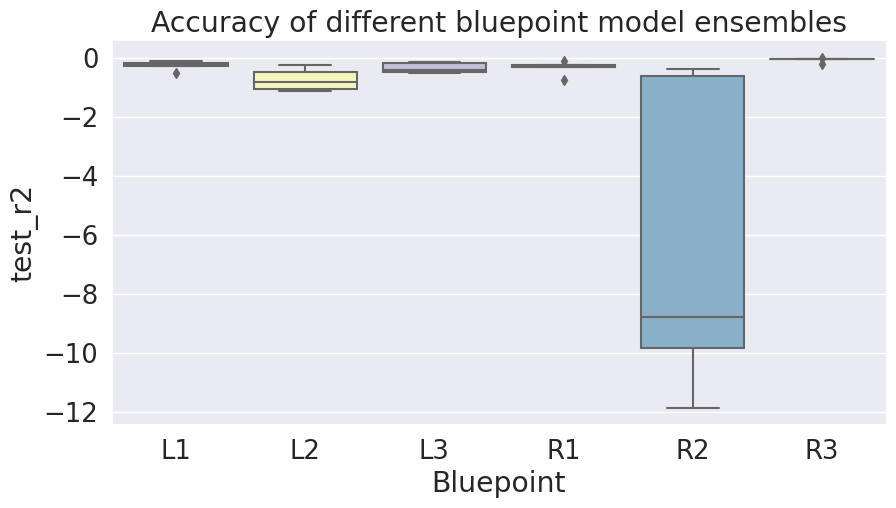

In [41]:
bluepoint_models = bluepoint_models.reset_index()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint", y="test_r2", palette="Set3")
plt.title("Accuracy of different bluepoint model ensembles")
plt.show()

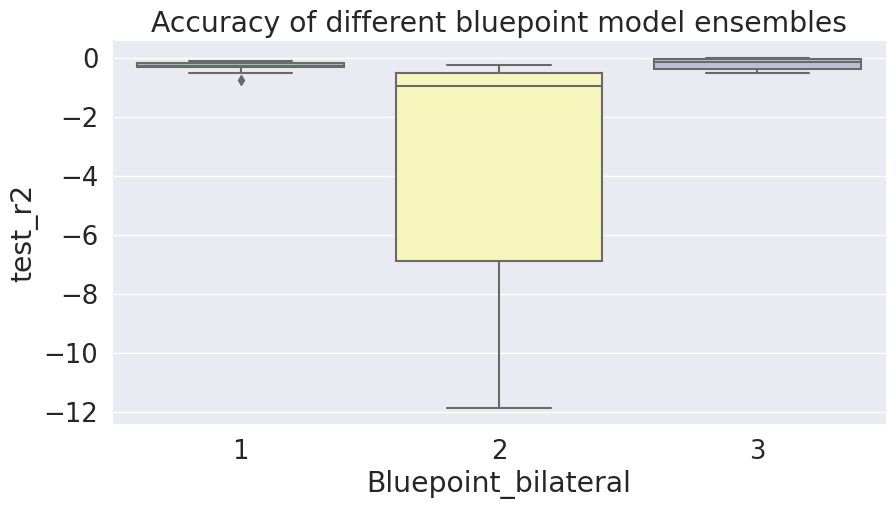

In [42]:
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bluepoint_models["Bluepoint_bilateral"] = bluepoint_models["Bluepoint"].apply(lambda x: x[1])

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint_bilateral", y="test_r2", palette="Set3")
plt.title("Accuracy of different bluepoint model ensembles")
plt.show()

In [43]:
bp_left = bluepoint_models_all.loc[["L1", "L2", "L3"]].test_r2
bp_right = bluepoint_models_all.loc[["R1", "R2", "R3"]].test_r2

bp_1 = bluepoint_models_all.loc[["L1", "R1"]].test_r2
bp_2 = bluepoint_models_all.loc[["L2", "R2"]].test_r2
bp_3 = bluepoint_models_all.loc[["L3", "R3"]].test_r2

p_values = []

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(bp_left, bp_right)
p_values.append(p_value)
print("Bluepoint left vs right")
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean test_r2 left: {bp_left.mean():.4f}")
print(f"Mean test_r2 right: {bp_right.mean():.4f}")

print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n Means:")
print(f"Mean test_r2 1: {bp_1.mean():.4f}")
print(f"Mean test_r2 2: {bp_2.mean():.4f}")
print(f"Mean test_r2 3: {bp_3.mean():.4f}")

Bluepoint left vs right
Mann–Whitney U Test: statistic=2861.0000, p-value=0.8568
Mean test_r2 left: -0.4482
Mean test_r2 right: -2.2306
Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=1447.0000, p-value=0.1755
2 vs 3
Mann–Whitney U Test: statistic=862.0000, p-value=0.0076
1 vs 3
Mann–Whitney U Test: statistic=1030.0000, p-value=0.1302

 Means:
Mean test_r2 1: -0.2981
Mean test_r2 2: -3.5200
Mean test_r2 3: -0.2001


In [44]:
# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")

test_distributions = ["L vs R", "1 vs 2", "2 vs 3", "1 vs 3"]
# Print green if p-value is significant otherwise red
for i, p in enumerate(p_adjusted[1]):
    if p < 0.05:
        print(f"\033[92m{test_distributions[i]}: {p:.4f}\033[0m")
    else:
        print(f"\033[91m{test_distributions[i]}: {p:.4f}\033[0m")



Bonferroni corrected p-values:
L vs R: 1.0000
1 vs 2: 0.7021
2 vs 3: 0.0302
1 vs 3: 0.5209


The models trained on L1 and R1 perform significantly better.